In [1]:
from tensorflow.keras.layers import Input,Dense,LSTM,Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD,Adam
from tensorflow.keras.callbacks import TensorBoard


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans

from sklearn.preprocessing import StandardScaler

In [3]:
df = []

markets = ["AUDUSD","EURUSD","GBPUSD","USDCAD","USDCHF","XAUUSD","NZDUSD"]

for market in  markets:
  df.append(pd.read_csv("Generated"+market+" dbot.csv"))

In [4]:
print(len(df))

7


In [5]:
n = 0 ## to select the market we want

In [6]:
df[n].head()

,Time,Open,Close,Tick Volume
0,1191484800,0.8810,0.8831,445
1,1191488400,0.8829,0.8817,430
2,1191492000,0.8818,0.8854,384
3,1191495600,0.8853,0.8849,448
4,1191499200,0.8850,0.8842,257


In [7]:
# Change the position of the 'B' column
df[n] = df[n][['Open', 'Tick Volume', 'Close']]
df[n].tail()

,Open,Tick Volume,Close
99994,0.65645,1321,0.65712
99995,0.65712,1585,0.65658
99996,0.65659,1361,0.65622
99997,0.65622,798,0.65634
99998,0.65634,531,0.65672


In [8]:
x = df[n].values

In [9]:
y = x[:,-1]
x = x[:,0:2]

np.set_printoptions(formatter={'float_kind': '{:.5f}'.format})

print(x)
print(y)

print(x.shape)
print(y.shape)

[[0.88100 445.00000]
 [0.88290 430.00000]
 [0.88180 384.00000]
 ...
 [0.65659 1361.00000]
 [0.65622 798.00000]
 [0.65634 531.00000]]
[0.88310 0.88170 0.88540 ... 0.65622 0.65634 0.65672]
(99999, 2)
(99999,)


In [21]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.02, random_state=0)


x_test = x_test[:-100]
y_test = y_test[:-100]



print(x_train.shape)
print(x_test.shape)



(97999, 2)
(1900, 2)


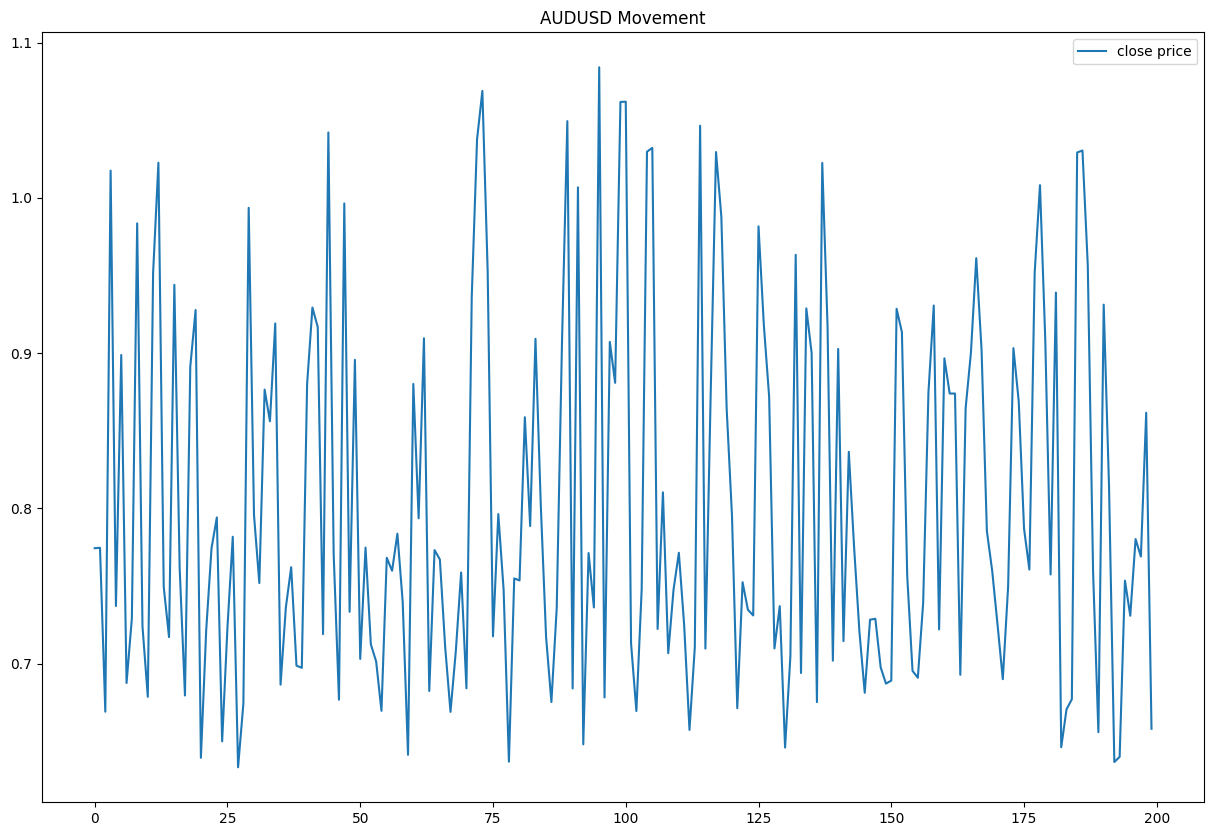

In [22]:
plt.figure(figsize=(15, 10))
plt.title(markets[n]+' Movement')
plt.plot(y_test[-200:], label="close price")
#plt.plot(x_test[-200:], label="open price")
plt.legend()
plt.show()

In [23]:
from sklearn.preprocessing import StandardScaler

sc_x = StandardScaler()
sc_y = StandardScaler()

x_train = sc_x.fit_transform(x_train)
y_train = sc_y.fit_transform(y_train.reshape((len(y_train),1)))
y_train = y_train.reshape(-1)

x_test = sc_x.transform(x_test)
y_test = sc_y.transform(y_test.reshape((len(y_test),1)))
y_test = y_test.reshape(-1)
print(x_train)
print(y_train)




[[-0.61593 -1.02472]
 [1.83269 0.51590]
 [-0.30885 2.12134]
 ...
 [0.93858 0.21793]
 [0.48172 0.70132]
 [-0.79659 -0.08256]]
[-0.61429 1.82042 -0.31803 ... 0.94063 0.48808 -0.79464]


In [24]:
timesteps = 1
samples = x_train.shape[0]
features = x_train.shape[1]

x_train = x_train[:samples*timesteps].reshape((samples, timesteps, features))

samples = x_test.shape[0]
features = x_test.shape[1]

x_test = x_test[:samples*timesteps].reshape((samples, timesteps, features))

print(x_train.shape)
print(x_test.shape)

(97999, 1, 2)
(1900, 1, 2)


In [25]:
print(x_train[0].shape)
print(x_test.shape)

(1, 2)
(1900, 1, 2)


In [15]:
i = Input(shape = x_train[0].shape)

X = LSTM(512, return_sequences=True)(i)
X = LSTM(256, return_sequences=True)(X)
X = LSTM(128, return_sequences=True)(X)
X = LSTM(128)(X)
X = Dense(128, activation="relu")(X)
X = Dense(1)(X)

model = Model(i, X)

model.compile(
    loss='mse',
    optimizer='adam'
)


r = model.fit(
    x_train,y_train,
    batch_size = 2048,
    epochs = 1000,
    validation_data = (x_test, y_test)

)

Epoch 1/1000
48/48 [==============================] - 14s 49ms/step - loss: 0.3956 - val_loss: 0.0131
Epoch 2/1000
48/48 [==============================] - 1s 18ms/step - loss: 0.0069 - val_loss: 0.0037
Epoch 3/1000
48/48 [==============================] - 1s 18ms/step - loss: 0.0026 - val_loss: 0.0017
Epoch 4/1000
48/48 [==============================] - 1s 18ms/step - loss: 0.0011 - val_loss: 6.6268e-04
Epoch 5/1000
48/48 [==============================] - 1s 18ms/step - loss: 4.7566e-04 - val_loss: 3.1204e-04
Epoch 6/1000
48/48 [==============================] - 1s 18ms/step - loss: 2.7001e-04 - val_loss: 2.0524e-04
Epoch 7/1000
48/48 [==============================] - 1s 19ms/step - loss: 1.9855e-04 - val_loss: 1.6398e-04
Epoch 8/1000
48/48 [==============================] - 1s 18ms/step - loss: 1.6708e-04 - val_loss: 1.4364e-04
Epoch 9/1000
48/48 [==============================] - 1s 18ms/step - loss: 1.5176e-04 - val_loss: 1.3305e-04
Epoch 10/1000
48/48 [=========================

In [26]:
def r_squared(y_true, y_pred):
  """Calculates the R-squared score.

  Args:
    y_true: The ground truth values.
    y_pred: The predicted values.

  Returns:
    The R-squared score.
  """

  mean_y_true = np.mean(y_true)
  ss_tot = np.sum((y_true - mean_y_true)**2)
  ss_res = np.sum((y_true - y_pred)**2)
  r_squared = 1 - ss_res / ss_tot
  return r_squared

y_pred = model.predict(x_test)
y_pred = y_pred.reshape(-1)
score = r_squared(y_test[-100:], y_pred[-100:])

print(score)

60/60 [==============================] - 0s 4ms/step
0.9997960881156138


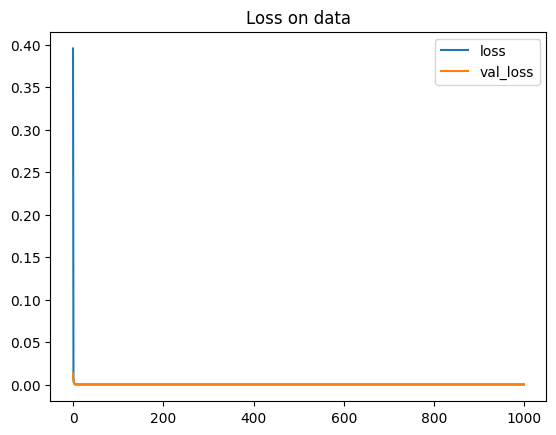

In [27]:
plt.title("Loss on data")
plt.plot(r.history['loss'], label="loss")
plt.plot(r.history['val_loss'], label="val_loss")
plt.legend()
plt.show()

In [28]:
y_test = sc_y.inverse_transform(y_test.reshape((len(y_test),1)))
y_pred = model.predict(x_test)
y_pred = sc_y.inverse_transform(y_pred.reshape((len(y_pred),1)))

60/60 [==============================] - 0s 5ms/step


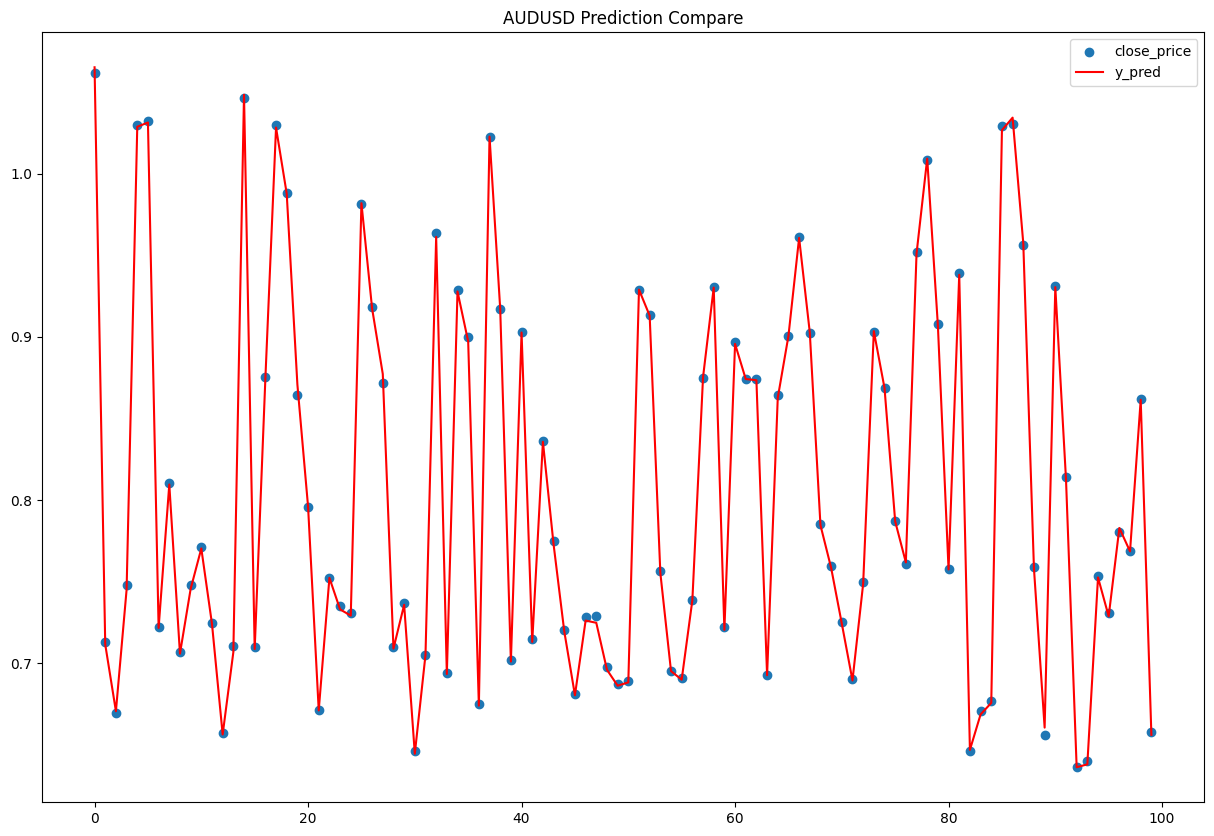

In [31]:
plt.figure(figsize=(15, 10))
plt.title(markets[n]+" Prediction Compare")
x_point = []

for i in range(len(y_test[-100:])):
  t = [i]
  x_point.append(t)
plt.scatter(x_point, y_test[-100:], label="close_price")
#plt.plot(y_test, label="y_test")

plt.plot(y_pred[-100:], label="y_pred", color="red")

plt.legend()

plt.show()

In [39]:
import MetaTrader5 as mt5
print("MetaTrader5 package author: ",mt5.__author__)
print("MetaTrader5 package version: ",mt5.__version__)

MetaTrader5 package author:  MetaQuotes Ltd.
MetaTrader5 package version:  5.0.45


In [40]:
if not mt5.initialize():
    print('Initialization failed, check internet connection. You must have Meta Trader 5 installed.')

else: 
    print(mt5.account_info()._asdict())
    print("\n")
    print(mt5.terminal_info()._asdict())

{'login': 75525372, 'trade_mode': 0, 'leverage': 100, 'limit_orders': 200, 'margin_so_mode': 0, 'trade_allowed': True, 'trade_expert': True, 'margin_mode': 2, 'currency_digits': 2, 'fifo_close': False, 'balance': 66.29, 'credit': 0.0, 'profit': 0.0, 'equity': 66.29, 'margin': 0.0, 'margin_free': 66.29, 'margin_level': 0.0, 'margin_so_call': 50.0, 'margin_so_so': 30.0, 'margin_initial': 0.0, 'margin_maintenance': 0.0, 'assets': 0.0, 'liabilities': 0.0, 'commission_blocked': 0.0, 'name': 'mike bright', 'server': 'MetaQuotes-Demo', 'currency': 'USD', 'company': 'MetaQuotes Software Corp.'}


{'community_account': True, 'community_connection': True, 'connected': True, 'dlls_allowed': False, 'trade_allowed': True, 'tradeapi_disabled': False, 'email_enabled': False, 'ftp_enabled': False, 'notifications_enabled': False, 'mqid': False, 'build': 4075, 'maxbars': 100000, 'codepage': 0, 'ping_last': 138817, 'community_balance': 0.0, 'retransmission': 0.12891233960906584, 'company': 'MetaQuotes So

In [43]:
rates = mt5.copy_rates_from_pos(markets[n], mt5.TIMEFRAME_H1, 0, 500)
#print(rates)
print(rates.shape)
data = []
close_price = []


for i in range(len(rates)):
    data.append([rates[i][1],rates[i][5]])
    close_price.append(rates[i][4])


data = np.array(data)
close_price = np.array(close_price)
data = sc_x.transform(data)

data = data.reshape((data.shape[0], 1, data.shape[1])) # 3 dimensaional data
print(data)


(500,)
[[[-1.42344 -0.38154]]

 [[-1.42289 -0.99206]]

 [[-1.42242 -0.85186]]

 [[-1.42156 -0.71971]]

 [[-1.42101 -0.11673]]

 [[-1.41568 -0.24034]]

 [[-1.40917 -0.41219]]

 [[-1.40761 -0.81870]]

 [[-1.40831 -0.83830]]

 [[-1.40949 -0.73931]]

 [[-1.41168 -0.75790]]

 [[-1.40510 -0.39561]]

 [[-1.40729 -0.06196]]

 [[-1.40643 -0.43279]]

 [[-1.39671 -0.55590]]

 [[-1.39671 -0.16748]]

 [[-1.39240 -0.07603]]

 [[-1.39342 0.08276]]

 [[-1.39154 0.91889]]

 [[-1.39389 -0.02025]]

 [[-1.39413 -0.39109]]

 [[-1.39726 -0.72775]]

 [[-1.39279 -0.85136]]

 [[-1.39209 -0.74735]]

 [[-1.39170 -1.03175]]

 [[-1.39460 -0.26496]]

 [[-1.39656 -1.00060]]

 [[-1.39993 -0.92824]]

 [[-1.39812 -0.30667]]

 [[-1.39781 0.14607]]

 [[-1.40079 -0.30215]]

 [[-1.40667 0.66263]]

 [[-1.41325 -0.65087]]

 [[-1.41623 -0.68253]]

 [[-1.41388 -0.47751]]

 [[-1.40957 0.01040]]

 [[-1.40502 0.07522]]

 [[-1.39420 -0.12879]]

 [[-1.39648 -0.33933]]

 [[-1.39797 -0.59811]]

 [[-1.40110 0.96110]]

 [[-1.41537 1.11

In [44]:
y_pred = model.predict(data)
  
y_pred = sc_y.inverse_transform(y_pred.reshape((len(y_pred),1)))
y_pred = y_pred.reshape(-1)

16/16 [==============================] - 0s 5ms/step


In [27]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1, 2)]            0         
                                                                 
 lstm (LSTM)                 (None, 1, 512)            1054720   
                                                                 
 lstm_1 (LSTM)               (None, 1, 256)            787456    
                                                                 
 lstm_2 (LSTM)               (None, 1, 128)            197120    
                                                                 
 lstm_3 (LSTM)               (None, 128)               131584    
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                                 
 dense_1 (Dense)             (None, 1)                 129   

In [32]:
model.save(markets[n]+".keras")

In [31]:
import joblib

joblib.dump(sc_x,markets[n]+ ' sc_x.joblib')
joblib.dump(sc_y,markets[n]+ ' sc_y.joblib')

['AUDUSD sc_y.joblib']

In [ ]:

from tensorflow.keras.models import load_model

model_list = [
    '/content/drive/MyDrive/forex data/metatrader 5 data H1/AUDUSD 1695376800.0.keras',
    '/content/drive/MyDrive/forex data/metatrader 5 data H1/EURGBP 1695376800.0.keras',
    '/content/drive/MyDrive/forex data/metatrader 5 data H1/EURUSD 1695376800.0.keras',
    '/content/drive/MyDrive/forex data/metatrader 5 data H1/GBPUSD 1695376800.0.keras',
    '/content/drive/MyDrive/forex data/metatrader 5 data H1/USDCAD 1695376800.0.keras',
    '/content/drive/MyDrive/forex data/metatrader 5 data H1/USDCHF 1695376800.0.keras',
    '/content/drive/MyDrive/forex data/metatrader 5 data H1/XAUUSD 1695362400.0.keras',
    "/content/drive/MyDrive/forex data/dbot_model.keras"
  ]

for target_list in model_list:
  # Load the Keras model
  model = load_model(target_list)
  model.save(target_list+".h5")
  # Convert the Keras model to ONNX
  #onnx_model = ox.convert_keras(model)

  # Save the ONNX model
  #onnx.save_model(onnx_model, target_list+'.onnx')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
import keras
import tensorflow as tf
print("Keras version:", keras.__version__)
print("TensorFlow version:", tf.__version__)

Keras version: 2.13.1
TensorFlow version: 2.13.0
